In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
os.getcwd()

'/Users/ilmaruduste/School/Masinõpe'

In [4]:
# os.chdir('/home/joonas/Documents/P29/grid_congestion_manager-main')
os.chdir('/Users/ilmaruduste/School/Masinõpe') #Ilmar
# os.chdir('E:\ML\grid_congestion_manager') #Sille PC

In [3]:
grid_load = pd.read_csv('grid_congestion_data/gridload.csv')
grid_locations = pd.read_csv('grid_congestion_data/grid_locations.csv')
ev_home = pd.read_csv('grid_congestion_data/ev_home_locations.csv')
public_chargers = pd.read_csv('grid_congestion_data/public_chargers_locations.csv')
ev_history = pd.read_csv('grid_congestion_data/ev_history.csv')
cars = pd.read_csv('grid_congestion_data/ev_models.csv')

### CLUSTERING

In [5]:
# find eucleidian distance between points (x1, y1) and (x2, y2)
def x_y_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2) 

# method adds closest grid cadaster to dataframe
def closest_grid_cadaster(location, grid):
    closest_grids = [] # list used to update dataframe later
    
    # iter over all locations
    for l in location.iterrows():
        # temp variables
        min_distance = None
        closest_grid = None
        
        # find distance from location l to all grids g
        for g in grid.iterrows():
            distance = x_y_distance(l[1].x, l[1].y, g[1].x, g[1].y)
            
            # if closer than previous closest grid, then overwrite
            if min_distance == None or distance < min_distance:
                min_distance = distance
                closest_grid = g[1].cadaster
                
        closest_grids.append(closest_grid)
    
    #update dataframe
    location.loc[:,"closest_grid_cadaster"] = closest_grids
    
closest_grid_cadaster(ev_home, grid_locations)
closest_grid_cadaster(public_chargers, grid_locations)

### SUBSTATION LOADS PROCESSING

In [6]:
#calculating baseloads

cadasters = grid_load['cadaster'].unique()
baseloads = dict()

for cadaster in cadasters: # lets make a empty dict with correct structure
    one_day_loads = np.zeros((24)) #24 hours in a day
    baseloads[cadaster] = one_day_loads

for index, row in grid_load.iterrows(): #insert correct elements into dict
    
    baseloads[row['cadaster']][row['time']-1] = row['baseload']


In [12]:
#make dict with different car model's chargning powers
charging_powers = dict()
for index, row in cars.iterrows():
    
    charging_powers[row['models']] = row['charge_power']

In [13]:
#make dict with loads from ev charging
ev_loads = dict()
for cadaster in cadasters: 
    one_day_loads = np.zeros((24)) #24 hours in a day
    ev_loads[cadaster] = one_day_loads

for index, row in ev_history.iterrows(): #scan over history
    if row['connected'] == True and row['charge_need'] != 0: #check if car is connected and needs charge
        
        cadaster_of_interest = row['cadaster'] #have to find out whats the closest substation for this cadaster
        
        for index, public_row in public_chargers.iterrows(): #scan public chargers
            if public_row['cadaster'] == cadaster_of_interest:
                ev_loads[public_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
                break     
        
        for index, home_row in ev_home.iterrows(): #scan home chargers
            if public_row['cadaster'] == cadaster_of_interest:
                ev_loads[home_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
                break

In [14]:
power_limits = dict()

for index, row in grid_locations.iterrows():
    power_limits[row['cadaster']] = row['max_current']

### LEGEND

In [15]:
#cadasters #all cadasters for substations
#baseloads #dictionary for baseloads for each substation (key: cadaster, value: 24 element array)
#ev_loads #dictionary for ev charging loads for each substation (key: cadaster, value: 24 element array)
#power_limits #dictionary for power limits for each substation (key: cadaster, value: 24 element array)

### EXAMPLE

Making the dictionaries into a Pandas DataFrame so I can visualise it in PlotNine.

In [47]:
loads_dataframe = pd.DataFrame.from_dict([baseloads, power_limits]).T
ev_loads_dataframe = pd.DataFrame.from_dict([ev_loads, power_limits]).T
loads_dataframe.columns = ['baseloads','power_limit']
ev_loads_dataframe.columns = ['ev_loads','power_limit']

loads_dataframe = baseloads_dataframe.explode('baseloads')
ev_loads_dataframe = ev_loads_dataframe.explode('ev_loads')
loads_dataframe['ev_loads'] = ev_loads_dataframe['ev_loads']

hour_array = []
for i in range(1200):
    hour_array.append(i%24)
loads_dataframe['hour'] = hour_array

loads_dataframe = loads_dataframe.reset_index()
loads_dataframe.columns = ['cadaster', 'baseloads', 'power_limit', 'ev_loads', 'hour']

loads_dataframe.head()
# print(loads_dataframe.shape)

,cadaster,baseloads,power_limit,ev_loads,hour
0,79511:003:0022,98.9976,200,0,0
1,79511:003:0022,104.894,200,0,1
2,79511:003:0022,85.2187,200,0,2
3,79511:003:0022,98.9416,200,0,3
4,79511:003:0022,79.8893,200,0,4


In [53]:
loads_dataframe['baseloads'] = loads_dataframe['baseloads'].astype('float')
loads_dataframe['power_limit'] = loads_dataframe['power_limit'].astype('float')
loads_dataframe['ev_loads'] = loads_dataframe['ev_loads'].astype('float')

loads_dataframe.dtypes

cadaster        object
baseloads      float64
power_limit    float64
ev_loads       float64
hour             int64
dtype: object

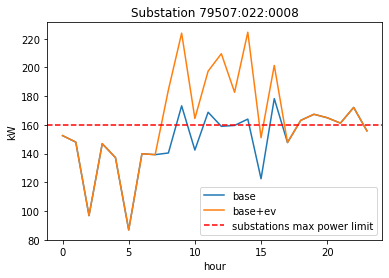

lol, see on alajaam on juba eos lappes


In [16]:
plt.plot(baseloads['79507:022:0008'], label = 'base')
plt.xlabel('hour')
plt.ylabel('kW')
plt.title('Substation 79507:022:0008')
plt.plot(baseloads['79507:022:0008']+ev_loads['79507:022:0008'], label = 'base+ev')
plt.axhline(y=power_limits['79507:022:0008'], color='r', linestyle='--',label = 'substations max power limit')
plt.legend()
plt.show()
print('lol, see on alajaam on juba eos lappes')

In [51]:
loads_dataframe['baseloads']

0       98.9976
1       104.894
2       85.2187
3       98.9416
4       79.8893
         ...   
1195    52.6347
1196    52.2141
1197    42.4593
1198    41.2504
1199    54.5247
Name: baseloads, Length: 1200, dtype: object

In [ ]:
# plotnine.options requires another import. This is a minor inconvenience, but it gets the job done
import plotnine

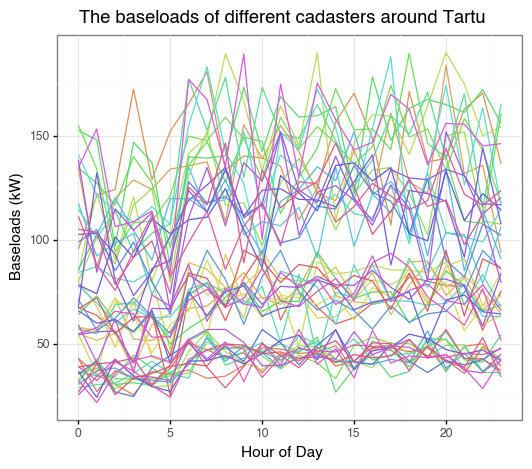

<ggplot: (7031183589)>

In [65]:

plotnine.options.figure_size = (6,5)

fig = (
    ggplot(data = loads_dataframe, mapping = aes(x = 'hour', color = 'cadaster')) + geom_line(mapping = aes(y='baseloads')) +
    theme_bw() + xlab('Hour of Day') + ylab('Baseloads (kW)') + scale_color_discrete(guide=False) + ggtitle('The baseloads of different cadasters around Tartu') +
    theme(text=element_text(family="Helvetica"))
)
fig

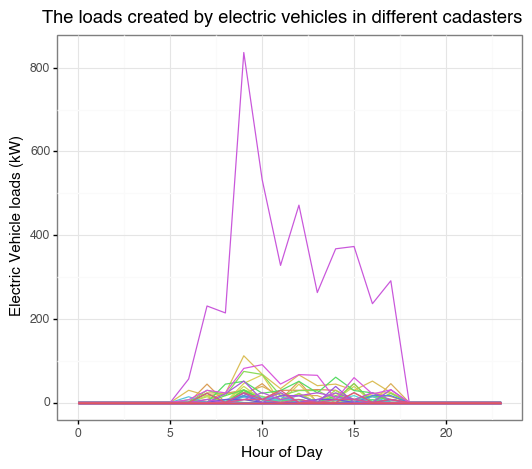

<ggplot: (7031962109)>

In [67]:

plotnine.options.figure_size = (6,5)

fig = (
    ggplot(data = loads_dataframe, mapping = aes(x = 'hour', color = 'cadaster')) + geom_line(mapping = aes(y='ev_loads')) +
    theme_bw() + xlab('Hour of Day') + ylab('Electric Vehicle loads (kW)') + scale_color_discrete(guide=False) + ggtitle('The loads created by electric vehicles in different cadasters') +
    theme(text=element_text(family="Helvetica"))
)
fig

In [76]:
avg_loads_dataframe = loads_dataframe.groupby('hour').mean().reset_index()
avg_loads_dataframe['combined_load'] = avg_loads_dataframe['baseloads'] + avg_loads_dataframe['ev_loads']
avg_loads_dataframe.head()

,hour,baseloads,power_limit,ev_loads,combined_load
0,0,73.630509,124.8,0.0,73.630509
1,1,71.749260,124.8,0.0,71.749260
2,2,68.833088,124.8,0.0,68.833088
3,3,70.612782,124.8,0.0,70.612782
4,4,70.814826,124.8,0.0,70.814826


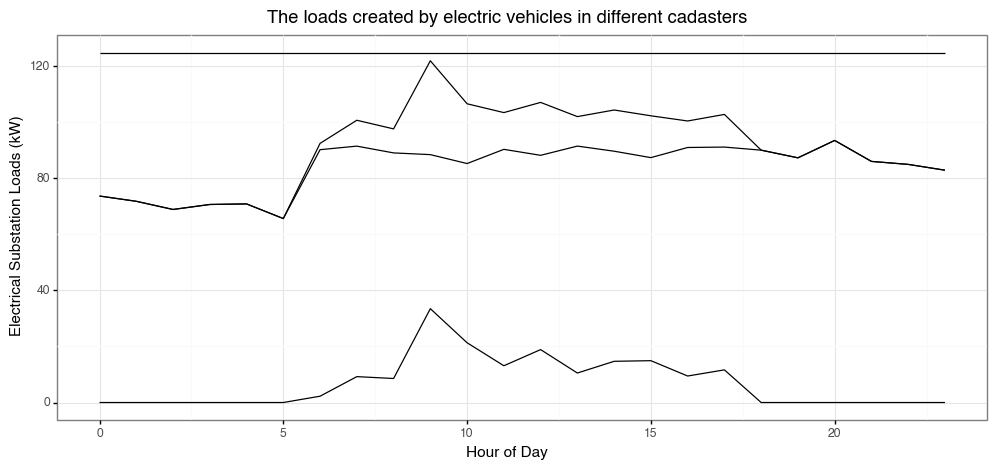

<ggplot: (7028486905)>

In [90]:

plotnine.options.figure_size = (12,5)

fig = (
    ggplot(data = avg_loads_dataframe, mapping = aes(x = 'hour')) + 
    geom_line(mapping = aes(y='ev_loads'), color="black") +
    geom_line(mapping = aes(y='baseloads')) +
    geom_line(mapping = aes(y='power_limit')) +
    geom_line(mapping = aes(y='combined_load')) +
    theme_bw() + xlab('Hour of Day') + ylab('Electrical Substation Loads (kW)') + scale_color_discrete(guide=False) + ggtitle('The loads created by electric vehicles in different cadasters') +
    theme(text=element_text(family="Helvetica"))
)
fig